In [9]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint
import glob

from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
import csv
comments=[]
with open('../SOCC/raw/gnm_comments.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            comments.append(row[5])
            line_count += 1
        if line_count>800:
            break
    print(f'Processed {line_count} lines.')

Column names are article_id, comment_counter, comment_author, timestamp, post_time, comment_text, TotalVotes, posVotes, negVotes, vote, reactions, replies, comment_id, parentID, threadID, streamId, edited, isModerator, highlightGroups, moderatorEdit, descendantsCount, threadTimestamp, flagCount, sender_isSelf, sender_loginProvider, data_type, is_empty, status
Processed 801 lines.


In [30]:
len(comments)

663173

In [3]:
def preprocess(input):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')

    bigram = gensim.models.Phrases(input, min_count=5, threshold=100) # higher threshold fewer phrases.
    
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
   
    # See trigram example
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

   
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(input)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp.max_length = 9297925
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return data_lemmatized

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(comments))

In [5]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

mallet_model=gensim.models.LdaModel.load('./models/model-050')

##pprint(mallet_model.print_topics(50,30))

##unwrap the model
model=gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50)

In [6]:
# Create Dictionary
id2word = mallet_model.id2word
# Create Corpus
texts = preprocess(data_words)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])
X=np.asarray(model.inference(corpus)[0])
num_topics=len(X[0])
##normalize it
X=(X.T/np.sum(X,axis=1)).T
Y=np.asarray([len(text) for text in texts])
useless_topics=[6,12,19,21,30,35,38,44]##remove non-topical features
for useless_topic in useless_topics:
    X[:,useless_topic]=0

[[(6, 1), (77, 1), (95, 1), (164, 1), (170, 1), (195, 1), (245, 1), (264, 1), (338, 1), (380, 1), (381, 1), (477, 1), (504, 1), (573, 1), (614, 2), (695, 1), (744, 1), (796, 1), (811, 1), (822, 1), (838, 1), (934, 1), (1006, 1), (1277, 1), (1387, 1), (1765, 1), (1796, 4), (2009, 1), (2111, 1), (2156, 1), (2164, 1), (2368, 1), (2410, 1), (2430, 1), (3087, 2), (4784, 1), (5258, 3), (5442, 1), (6214, 1), (9141, 1), (10538, 1), (11765, 1), (19024, 1), (60072, 1), (137671, 1)]]


In [7]:
import pickle
f=open("./models/forest.pkl","rb")
forest=pickle.loads(f.read())
f.close()

predictions:   [51 25 16 45 39 48 45 29 51  2 25 99  4  4  1 59  7 16]
actual length: [ 58  25  17  41  40  45  54  26  46   2  29 132   5   7   1  63   7  17]


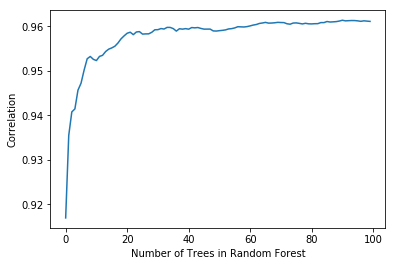

In [10]:
from scipy.stats.stats import pearsonr
correlations=[]
for size in range (1,101):
    predictions=forest[0].predict(X)
    for i in range(1,size):
        predictions+=forest[i].predict(X)
    correlations.append(pearsonr(predictions/size,Y)[0])
print("predictions:  ",np.asarray(predictions[0:18]/100,dtype=int))
print("actual length:",Y[0:18])
plt.plot(correlations)
plt.xlabel("Number of Trees in Random Forest")
plt.ylabel("Correlation")
plt.show()

In [11]:
correlations

[0.9169849019785585,
 0.9355079217459671,
 0.9407786012054822,
 0.9414464918551256,
 0.9456573513828723,
 0.9472207426568469,
 0.9501605291210498,
 0.952704778509728,
 0.9532228291846607,
 0.9525815302160444,
 0.9523016859538135,
 0.9532334017042638,
 0.9534774654781749,
 0.9543288664921058,
 0.9548646789211653,
 0.9551425384372996,
 0.9555172256842647,
 0.9562332310933185,
 0.9571698070363589,
 0.957840683499449,
 0.9584339728431689,
 0.9586646524735537,
 0.9581143091235196,
 0.9587171772408192,
 0.9587972939790388,
 0.9582391417016506,
 0.958288034464286,
 0.9582976451026399,
 0.9586418684147812,
 0.9592095633583612,
 0.9592380810742406,
 0.9594861865398593,
 0.9593799573564755,
 0.9597473216489344,
 0.9597389925832043,
 0.9594743039110027,
 0.9589152324436249,
 0.9594447349530735,
 0.9593530527124858,
 0.959469193058314,
 0.9593467353729067,
 0.959708925376372,
 0.9596470477260147,
 0.9597157564744127,
 0.959510706012119,
 0.959356901367087,
 0.9593629399352855,
 0.9593645533563508,